In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from subject_clf.dataset_imperial import dataset, subjects, short_term_weights_path
from subject_clf.subject_net import SubjectNet
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import itertools
from common.quaternion import *
from math import pi
torch.cuda.set_device(1)


In [2]:
from long_term.dataset_imperial import dataset, long_term_weights_path
from long_term.locomotion_utils import build_extra_features, compute_splines
from long_term.pose_network_long_term import  PoseNetworkLongTerm
from common.spline import Spline
from common.visualization_patrick import render_animation, render_animation_dual

if torch.cuda.is_available():
    dataset.cuda()
dataset.compute_euler_angles('yzx')
dataset.compute_positions()
build_extra_features(dataset)

from long_term.pace_network import PaceNetwork

traj = np.array([[-i*0.1,0] for i in range(1737)])
pace_net = PaceNetwork()
pace_net.load_weights('weights_pace_network.bin')
spline = Spline(traj, closed=False)

Loading weights from weights_pace_network.bin


# parameters: 9545250
Loading weights from weights_long_term.bin


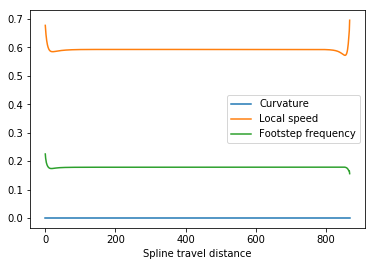

In [3]:
# We want the character to walk
%matplotlib inline
spline_walk = pace_net.predict(spline, average_speed=0.5)
plt.plot(spline_walk.get_track('curvature'))
plt.plot(spline_walk.get_track('amplitude'))
plt.plot(spline_walk.get_track('frequency'))
plt.legend(['Curvature', 'Local speed', 'Footstep frequency'])
_ = plt.xlabel('Spline travel distance')

model = PoseNetworkLongTerm(32, dataset.skeleton())
if torch.cuda.is_available():
    model.cuda()
model.load_weights('weights_long_term.bin') # Load pretrained model

1684 frames generated in 1.655 seconds (1017.29 FPS)


<IPython.core.display.Javascript object>


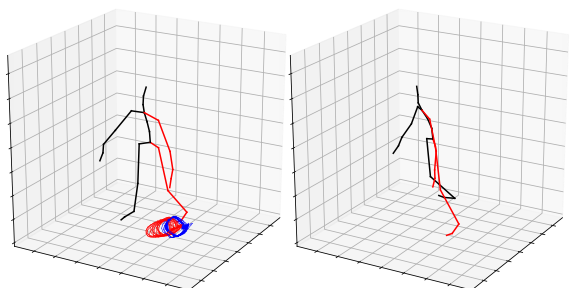

In [5]:
traj = np.array([[i,0] for i in range(1000)])
spline = Spline(traj, closed=False)
spline_walk = pace_net.predict(spline, average_speed=0.5)

spline_walk.tracks['direction'][0][:,0] = 1
spline_walk.tracks['direction'][0][:,1] = 1

%matplotlib notebook
prediction, rotations = model.generate_motion(spline_walk, dataset['Subject4']['walking_2_d1'])
anim = render_animation_dual(dataset['Subject4']['walking_2_d1']['positions_world'][model.prefix_length:],
                             prediction, dataset.skeleton(), dataset.fps(), output='interactive')

Traceback (most recent call last):
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


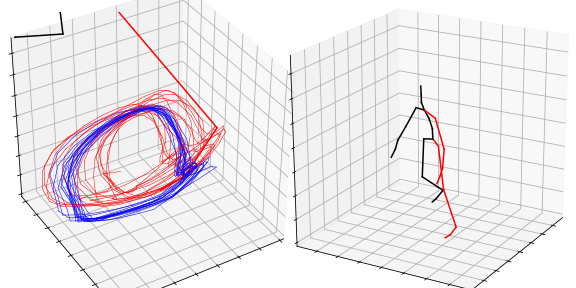

In [21]:
%matplotlib notebook

zoom_right_arm = [-0/10,2/10,-3/10,-1/10,3/10,5/10]
zoom_left_foot = [-0.8/10,1.2/10,1/10,3/10,0/10,2/10]

prediction_test = prediction.copy()
for i in range(prediction_test.shape[0]):
    v = np.array(prediction_test[i,:,:])
    #q = np.array([[0,0,1,0] for _ in range(v.shape[0])])
    q = np.tile(euler_to_quaternion(np.array([[0,-pi/6.5,0]]),'zyx'),(27,1))
    prediction_test[i] = qrot_np(q,v)
anim = render_animation_dual(dataset['Subject4']['walking_2_d1']['positions_world'][model.prefix_length:][:],
                             prediction_test[:], dataset.skeleton(), dataset.fps(), output='interactive',zoom=[-0.8/10,1.2/10,1/10,3/10,0/10,2/10])

In [10]:
from common.quaternion import *
from math import pi
import torch
import numpy as np

In [67]:
print(q.shape[:-1])
print(v.shape[:-1])

(1,)
(27,)


In [60]:
v = np.array(prediction[1,:,:])
q = np.array([[0,0,1,15*pi/180] for _ in range(v.shape[0])])

In [61]:
qrot_np(q,v)

array([[ 0.        ,  0.01996799,  0.01211606],
       [ 0.2866405 , -0.36300545,  0.42212108],
       [ 0.74362388, -1.89150381, -0.33574918],
       [ 1.82168829, -2.6524021 , -1.52796652],
       [ 1.55039221, -2.93937301, -1.21055571],
       [ 1.32367698, -2.98836537, -1.10364857],
       [-0.4408574 ,  0.13141336, -0.41635915],
       [-0.64341918, -1.22827758, -1.58350536],
       [-0.58008333, -2.41009852, -2.79902522],
       [-1.10989825, -2.52300392, -2.72477029],
       [-1.3038537 , -2.61156843, -2.56032429],
       [ 0.00668642,  0.39496684,  0.26148669],
       [-0.08548438,  0.7140471 ,  0.5806151 ],
       [-0.22765317,  1.0021718 ,  0.9180458 ],
       [-0.33520575,  1.25235553,  1.17461691],
       [-0.42190717,  1.55420949,  1.35510605],
       [-0.34839499,  1.91491293,  1.35185363],
       [ 0.38074111,  0.60975578,  1.39131445],
       [ 1.08074858, -0.52582417,  1.25387188],
       [ 1.18239378, -1.24142815,  1.54201182],
       [ 1.14570561, -1.61582314,  1.582

In [63]:
for i in range(prediction.shape[0]):
    v = np.array(prediction[i,:,:])
    q = np.array([[0,0,1,15*pi/180] for _ in range(v.shape[0])])
    prediction[i] = qrot_np(q,v)

In [64]:
prediction[1]

array([[ 0.        ,  0.01996799,  0.01211606],
       [ 0.2866405 , -0.36300546,  0.42212108],
       [ 0.74362385, -1.8915038 , -0.33574918],
       [ 1.8216883 , -2.6524022 , -1.5279665 ],
       [ 1.5503923 , -2.939373  , -1.2105557 ],
       [ 1.323677  , -2.9883654 , -1.1036485 ],
       [-0.4408574 ,  0.13141336, -0.41635916],
       [-0.6434192 , -1.2282776 , -1.5835054 ],
       [-0.5800833 , -2.4100986 , -2.7990253 ],
       [-1.1098982 , -2.5230038 , -2.7247703 ],
       [-1.3038538 , -2.6115685 , -2.5603242 ],
       [ 0.00668642,  0.39496684,  0.26148668],
       [-0.08548438,  0.7140471 ,  0.5806151 ],
       [-0.22765318,  1.0021718 ,  0.9180458 ],
       [-0.33520576,  1.2523556 ,  1.1746169 ],
       [-0.4219072 ,  1.5542095 ,  1.355106  ],
       [-0.348395  ,  1.9149129 ,  1.3518536 ],
       [ 0.38074112,  0.60975575,  1.3913145 ],
       [ 1.0807486 , -0.5258242 ,  1.2538719 ],
       [ 1.1823938 , -1.2414281 ,  1.5420119 ],
       [ 1.1457056 , -1.6158231 ,  1.582